In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4,5,6,7
no_gpu = 4
%matplotlib inline
import numpy as np
import pandas as pd
from __future__ import print_function
import os
import cPickle as pickle
import math
from time import time
from datetime import datetime
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
np.random.seed(1337)  # for reproducibility

nb_epoch = 500  # number of epoch at training stage
nb_epoch_cont = 100  # number of epoch at training (cont) stage
batch_size = 15  # batch size

lr = 0.0002  # learning rate
len_closeness = 15  # length of closeness dependent sequence
nb_residual_unit = 16   # number of residual units
year_test = 2005
nb_flow = 1  # there are two types of flows: new-flow and end-flow
path_result = 'RET'
path_model = 'MODEL'

if os.path.isdir(path_result) is False:
    os.mkdir(path_result)
if os.path.isdir(path_model) is False:
    os.mkdir(path_model)
data_path = '/notebooks/workspace/flood/www.ncei.noaa.gov/data/precipitation-persiann/'

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4,5,6,7


Using TensorFlow backend.


### Load Data

In [2]:
from persiann import sample_construction
if os.path.isfile('X.npy') is False: 
    print ('start creating samples.')
    sc = sample_construction(data_path=data_path,end_year=2016)
    sc.create_samples(target_river = 'G')

In [3]:
E = np.load('E.npy') #external input
X = np.load('X.npy')
Y = pd.read_pickle('Y_df.pkl')
map_height, map_width = X.shape[2], X.shape[3]
print('E: ',E.shape,'X: ',X.shape,'Y: ',Y.shape)

E:  (4148, 5) X:  (4148, 15, 92, 188) Y:  (4148, 1)


In [4]:
train_idx  = Y.index.year < year_test
test_idx  = Y.index.year >= year_test
#X=np.reshape(X,(:, np.newaxis,...))
X = X[:, np.newaxis,...]
E_train, X_train, Y_train, E_test, X_test, Y_test = E[train_idx], X[train_idx],Y.iloc[train_idx],E[test_idx],X[test_idx],Y.iloc[test_idx]
print ('E_train shape', E_train.shape,'X_train shape', X_train.shape, 'Y_train shape', Y_train.shape,'E_test shape', E_test.shape,'X_test shape', X_test.shape, 'Y_test shape', Y_test.shape)

E_train shape (2684, 5) X_train shape (2684, 1, 15, 92, 188) Y_train shape (2684, 1) E_test shape (1464, 5) X_test shape (1464, 1, 15, 92, 188) Y_test shape (1464, 1)


### Build Network

In [5]:
from keras import backend as K
#Root Mean Squared Error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
#Root Mean Squared Logarithmic Error
def rmsle(y_true, y_pred):
    return K.sqrt(K.mean(K.square(tf.log1p(y_pred) - tf.log1p(y_true))))

In [6]:
import residualnet as rn
from keras.utils import multi_gpu_model

def build_model(external_dim):
    c_conf = (len_closeness, nb_flow, map_height,
              map_width) if len_closeness > 0 else None

    model = rn.stresnet(c_conf=c_conf, p_conf=None, t_conf=None,
                     external_dim=external_dim, nb_residual_unit=nb_residual_unit, is_3D=True, batchNormalization=False) 
    
    parallel_model = multi_gpu_model(model, gpus=no_gpu)
    
    adam = Adam(lr=lr)
    parallel_model.compile(loss='mse', optimizer=adam, metrics=[rmse])
    parallel_model.summary()
    # from keras.utils.visualize_util import plot
    # plot(model, to_file='model.png', show_shapes=True)
    return parallel_model

In [7]:
external_dim = E_train.shape[1]
model = build_model(external_dim)
hyperparams_name = 'c{}.resunit{}.lr{}'.format(
    len_closeness, nb_residual_unit, lr)
fname_param = os.path.join('MODEL', '{}.best.h5'.format(hyperparams_name))

early_stopping = EarlyStopping(monitor='val_rmse', patience=5, mode='min')
model_checkpoint = ModelCheckpoint(
    fname_param, monitor='val_rmse', verbose=0, save_best_only=True, mode='min')

(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
(?, 64, 15, 92, 188)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 15, 92, 18 0                                            
_______________________________

### Training with early stopping

In [8]:
print("training model...")
X_tr=[X_train,E_train]
X_te=[X_test,E_test]
history = model.fit(X_tr, Y_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[early_stopping, model_checkpoint],
                    verbose=1)
model.save_weights(os.path.join(
    path_model, '{}.h5'.format(hyperparams_name)), overwrite=True)
pickle.dump((history.history), open(os.path.join(
    path_result, '{}.history.pkl'.format(hyperparams_name)), 'wb'))

training model...
Train on 2415 samples, validate on 269 samples
Epoch 1/500
2415/2415 [==============================] - 15s 6ms/step - loss: 378586204.6211 - rmse: 15461.0148 - val_loss: 161635502.1784 - val_rmse: 10449.2832
Epoch 2/500
2415/2415 [==============================] - 10s 4ms/step - loss: 190821172.8447 - rmse: 11251.5602 - val_loss: 95190605.2286 - val_rmse: 7890.0823
Epoch 3/500
2415/2415 [==============================] - 10s 4ms/step - loss: 130957258.5093 - rmse: 8797.8480 - val_loss: 63375474.5720 - val_rmse: 6389.4141
Epoch 4/500
2415/2415 [==============================] - 10s 4ms/step - loss: 104264065.3913 - rmse: 7631.1697 - val_loss: 71925922.5260 - val_rmse: 6915.2148
Epoch 5/500
2415/2415 [==============================] - 9s 4ms/step - loss: 90482600.9441 - rmse: 7076.7671 - val_loss: 64889167.6989 - val_rmse: 6679.8357
Epoch 6/500
2415/2415 [==============================] - 9s 4ms/step - loss: 80983311.3043 - rmse: 6642.0940 - val_loss: 57809280.4145 - v

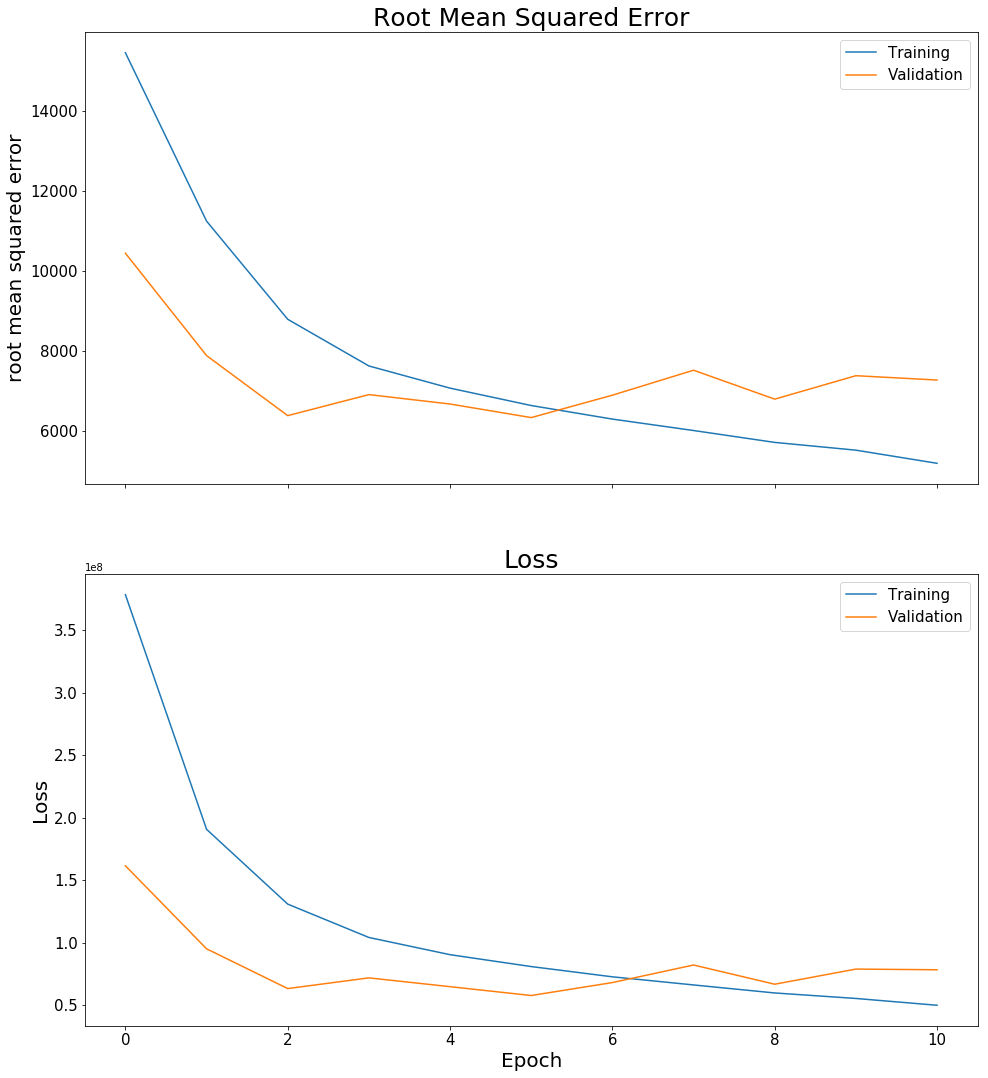

In [9]:
# summarize history for root mean squared error
f, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
f.set_size_inches(16, 8)
f.subplots_adjust(top=1.85)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title('Root Mean Squared Error',size=25)
ax1.set_ylabel('root mean squared error',size=20)
#ax1.set_xlabel('epoch',size=20)
rmse_train=ax1.plot(history.history['rmse'])
rmse_val=ax1.plot(history.history['val_rmse'])
ax1.legend( ( rmse_train[0], rmse_val[0]), ('Training','Validation'),fontsize=15)

ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_title('Loss',size=25)
ax2.set_ylabel('Loss',size=20)
ax2.set_xlabel('Epoch',size=20)
loss_train=ax2.plot(history.history['loss'])
loss_val=ax2.plot(history.history['val_loss'])

ax2.legend( ( loss_train[0], loss_val[0]), ('Training','Validation'),fontsize=15)
plt.show()

### Evaluation using the model given by early stopping

In [10]:
print('=' * 50)
print('evaluating using the model that has the best loss on the valid set')
model.load_weights(fname_param)
score = model.evaluate(X_tr, Y_train, batch_size=batch_size, verbose=0)
print('Train score: %.6f rmse (norm): %.6f' %
      (score[0], score[1]))

score = model.evaluate(
    X_te, Y_test, batch_size=batch_size, verbose=0)
print('Test score: %.6f rmse (norm): %.6f' %
      (score[0], score[1]))


evaluating using the model that has the best loss on the valid set
Train score: 72999993.444695 rmse (norm): 6420.097430
Test score: 100819120.095927 rmse (norm): 7483.365467


### Continue training without early stopping

In [11]:
print('=' * 50)
print("training model (cont)...")
fname_param = os.path.join(
    path_model, '{}.cont.best.h5'.format(hyperparams_name))
model_checkpoint = ModelCheckpoint(
    fname_param, monitor='rmse', verbose=0, save_best_only=True, mode='min')
history = model.fit(X_tr, Y_train, epochs=nb_epoch_cont, verbose=1, batch_size=batch_size, callbacks=[
                    model_checkpoint], validation_data=(X_te, Y_test))
pickle.dump((history.history), open(os.path.join(
    path_result, '{}.cont.history.pkl'.format(hyperparams_name)), 'wb'))
model.save_weights(os.path.join(
    path_model, '{}_cont.h5'.format(hyperparams_name)), overwrite=True)

print('=' * 10)
print('evaluating using the final model')
score = model.evaluate(X_tr, Y_train, batch_size=batch_size, verbose=0)
print('Train score: %.6f rmse (norm): %.6f' %
      (score[0], score[1]))
score = model.evaluate(
    X_te, Y_test, batch_size=batch_size, verbose=0)
print('Test score: %.6f rmse (norm): %.6f' %
      (score[0], score[1]))


training model (cont)...
Train on 2684 samples, validate on 1464 samples
Epoch 1/100
2684/2684 [==============================] - 13s 5ms/step - loss: 71695770.1393 - rmse: 6359.9408 - val_loss: 104402432.4834 - val_rmse: 7625.3098
Epoch 2/100
2684/2684 [==============================] - 13s 5ms/step - loss: 64536123.4292 - rmse: 6007.9066 - val_loss: 106063125.9890 - val_rmse: 7705.2619
Epoch 3/100
2684/2684 [==============================] - 14s 5ms/step - loss: 59510092.4247 - rmse: 5748.2762 - val_loss: 131697920.7126 - val_rmse: 8712.4663
Epoch 4/100
2684/2684 [==============================] - 13s 5ms/step - loss: 53457931.1982 - rmse: 5475.8157 - val_loss: 122202997.1122 - val_rmse: 8362.1421
Epoch 5/100
2684/2684 [==============================] - 13s 5ms/step - loss: 48763051.9516 - rmse: 5224.4449 - val_loss: 112364703.1204 - val_rmse: 7983.6644
Epoch 6/100
2684/2684 [==============================] - 13s 5ms/step - loss: 45445494.5551 - rmse: 5027.1504 - val_loss: 142032698.

2684/2684 [==============================] - 13s 5ms/step - loss: 1801634.3397 - rmse: 1030.7761 - val_loss: 153262794.5272 - val_rmse: 9470.7150
Epoch 52/100
2684/2684 [==============================] - 13s 5ms/step - loss: 1680178.7922 - rmse: 986.9382 - val_loss: 147416171.8571 - val_rmse: 9282.7602
Epoch 53/100
2684/2684 [==============================] - 13s 5ms/step - loss: 1635370.6591 - rmse: 970.5209 - val_loss: 139358386.9216 - val_rmse: 9020.1322
Epoch 54/100
2684/2684 [==============================] - 13s 5ms/step - loss: 1619137.6318 - rmse: 967.3852 - val_loss: 146162486.5087 - val_rmse: 9251.4761
Epoch 55/100
2684/2684 [==============================] - 13s 5ms/step - loss: 1567018.5277 - rmse: 942.8285 - val_loss: 142729429.2669 - val_rmse: 9127.1549
Epoch 56/100
2684/2684 [==============================] - 13s 5ms/step - loss: 1373093.3725 - rmse: 871.8984 - val_loss: 145395599.3473 - val_rmse: 9216.3985
Epoch 57/100
2684/2684 [==============================] - 13s 5m

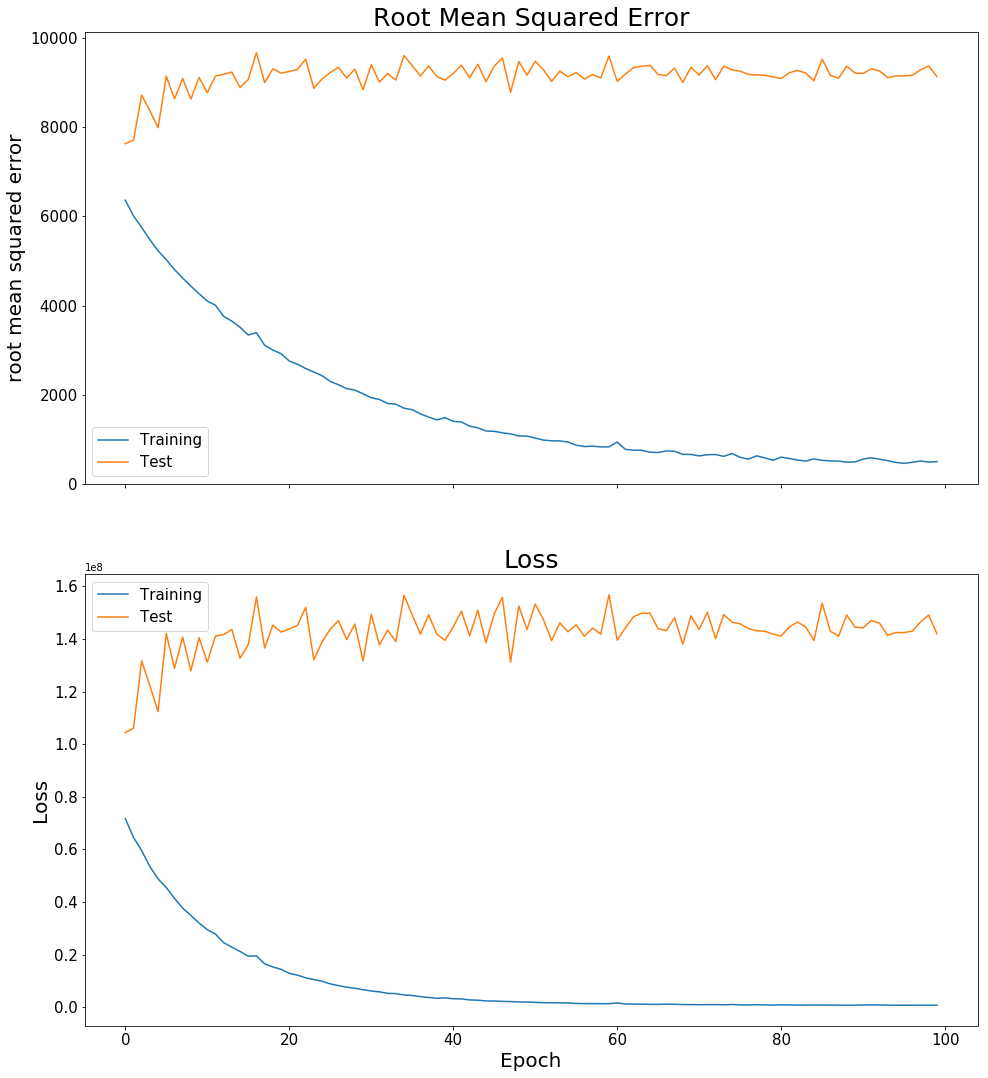

In [12]:
# summarize history for root mean squared error
f, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
f.set_size_inches(16, 8)
f.subplots_adjust(top=1.85)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_title('Root Mean Squared Error',size=25)
ax1.set_ylabel('root mean squared error',size=20)
#ax1.set_xlabel('epoch',size=20)
rmse_train=ax1.plot(history.history['rmse'])
rmse_val=ax1.plot(history.history['val_rmse'])
ax1.legend( ( rmse_train[0], rmse_val[0]), ('Training','Test'),fontsize=15)

ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_title('Loss',size=25)
ax2.set_ylabel('Loss',size=20)
ax2.set_xlabel('Epoch',size=20)
loss_train=ax2.plot(history.history['loss'])
loss_val=ax2.plot(history.history['val_loss'])

ax2.legend( ( loss_train[0], loss_val[0]), ('Training','Test'),fontsize=15)
plt.show()